In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
# torch.autograd.set_detect_anomaly(True)
# torch.autograd.detect_anomaly(check_nan=True)
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
import pickle
import os

from ppo import PPO

In [2]:
# environment hyperparams
n_envs = 10 # 10
n_updates = 1000 # 32*1000
n_steps_per_update = 129
randomize_domain = False
# NOTE: add bs, epochs
batch_size = 64
n_epochs = 4
epsilon = 0.2

# agent hyperparams
gamma = 0.999 # 0.999
# return gae lam=1?
lam = 1 # 0.95 # TODO:hyperparameter for GAE
ent_coef = 0.01  # coefficient for the entropy bonus (to encourage exploration)
actor_lr = 0.001
critic_lr = 0.005

debug_once = False


envs = gym.vector.make("LunarLander-v2", num_envs=n_envs, ) # max_episode_steps=600
# TODO: how to handle truncation 

obs_shape = envs.single_observation_space.shape[0]
action_shape = envs.single_action_space.n

# set the device
use_cuda = False
if use_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

# init the agent
agent = PPO(n_features=obs_shape, n_actions=action_shape, device=device, critic_lr=critic_lr, actor_lr=actor_lr, gamma=gamma, ent_coef=ent_coef, epsilon=epsilon, n_envs=n_envs)

/home/zhaoyutian/rl/lib/python3.10/site-packages/gymnasium/vector/__init__.py:53: UserWarning: WARN: `gymnasium.vector.make(...)` is deprecated and will be replaced by `gymnasium.make_vec(...)` in v1.0
  gym.logger.warn(


In [3]:
envs_wrapper = gym.wrappers.RecordEpisodeStatistics(envs, deque_size=n_envs * n_updates)

critic_losses = []
actor_losses = []
entropies = []

# use tqdm to get a progress bar for training
for sample_phase in tqdm(range(n_updates)):
    # we don't have to reset the envs, they just continue playing
    # until the episode is over and then reset automatically

    # reset lists that collect experiences of an episode (sample phase)
    # NOTE: record states and entropies
    ep_states = torch.zeros(n_steps_per_update, n_envs, obs_shape, device=device)
    ep_actions = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_entropies = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_rewards = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
    masks = torch.zeros(n_steps_per_update, n_envs, device=device)

    # at the start of training reset all envs to get an initial state
    # TODO: seed
    if sample_phase == 0:
        states, info = envs_wrapper.reset(seed=42)

    # play n steps in our parallel environments to collect data
    for step in range(n_steps_per_update):
        # select an action A_{t} using S_{t} as input for the agent
        ep_states[step] = torch.tensor(states, device=device)
        with torch.no_grad():
            actions, action_log_probs, state_value_preds, entropy = agent.select_action(
                states
            )

            if debug_once:
                print(actions, action_log_probs, state_value_preds, entropy)
                debug_once = False

        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        states, rewards, terminated, truncated, infos = envs_wrapper.step(
            actions.cpu().numpy()
        )

        ep_value_preds[step] = torch.squeeze(state_value_preds)
        ep_rewards[step] = torch.tensor(rewards, device=device)
        ep_action_log_probs[step] = action_log_probs
        ep_entropies[step] = torch.squeeze(entropy)
        ep_actions[step] = torch.squeeze(actions)
        # add a mask (for the return calculation later);
        # for each env the mask is 1 if the episode is ongoing and 0 if it is terminated (not by truncation!)
        # TODO: check masks
        masks[step] = torch.tensor([int(not term) for term in terminated])

    # compute gae
    advantages = torch.zeros(n_steps_per_update, n_envs, device=device)
    gae = torch.zeros(n_envs, device=device)
    for t in reversed(range(n_steps_per_update - 1)):
        td_error = (
            ep_rewards[t] + gamma * masks[t] * ep_value_preds[t + 1] - ep_value_preds[t]
        )
        gae = td_error + gamma * lam * masks[t] * gae
        advantages[t] = gae
    
    returns = advantages + ep_value_preds
    # normalize advantages
    advantages = (advantages-advantages.mean())/(advantages.std()) # +1e-05

    # mini-batch update
    # NOTE: ignore the last step
    ep_actions = ep_actions[:-1].reshape((-1, 1))
    ep_cur_states = ep_states[:-1].reshape((-1, obs_shape))
    ep_next_states = ep_states[1:].reshape((-1, obs_shape))
    # ep_entropies = ep_entropies[:-1].reshape((-1, 1))
    # ep_cur_value_preds = ep_value_preds[:-1].reshape((-1, 1))
    # ep_next_value_preds = ep_value_preds[1:].reshape((-1, 1))
    ep_rewards = ep_rewards[:-1].reshape((-1, 1))
    ep_action_log_probs = ep_action_log_probs[:-1].reshape((-1, 1)) # .detach()
    masks = masks[:-1].reshape((-1, 1))
    advantages = advantages[:-1].reshape((-1, 1)) # .detach()
    returns = returns[:-1].reshape((-1, 1)) 
    inds = np.arange(len(ep_rewards))
    for _ in range(n_epochs):
        # np.random.shuffle(inds)
        for i in range(0, len(ep_rewards), batch_size):
            # agent.critic_optim.zero_grad()
            # agent.actor_optim.zero_grad()
            # print("=============", i)
            batch_inds = inds[i:i+batch_size]

            # calculate the losses for actor and critic
            critic_loss, actor_loss = agent.get_losses(
                actions=ep_actions[batch_inds],
                states=ep_cur_states[batch_inds],
                action_k_log_probs=ep_action_log_probs[batch_inds],
                advantages=advantages[batch_inds],
                returns=returns[batch_inds],
                masks=masks[batch_inds],
                rewards=ep_rewards[batch_inds],
                next_states=ep_next_states[batch_inds],
            ) # target_value, pred_value, critic_target_value, debug_reward, debug_gamma

            # update the actor and critic networks
            agent.update_parameters(critic_loss, actor_loss)
            
    # agent.actor_k.load_state_dict(agent.actor.state_dict())

            # log the losses and entropy
            critic_losses.append(critic_loss.detach().cpu().numpy())
            actor_losses.append(actor_loss.detach().cpu().numpy())
    entropies.append(ep_entropies.mean().cpu().numpy())

100%|██████████| 1000/1000 [07:18<00:00,  2.28it/s]


In [4]:
# action_pd = torch.distributions.Categorical(
#     logits=torch.randn((64,4))
# )  # implicitly uses softmax
# action_pd.log_prob(torch.ones((64))).shape

# with torch.no_grad():
#     critic_target_value = agent.critic_target(ep_next_states)

# torch.mean(torch.abs(ep_rewards+gamma*masks*critic_target_value))

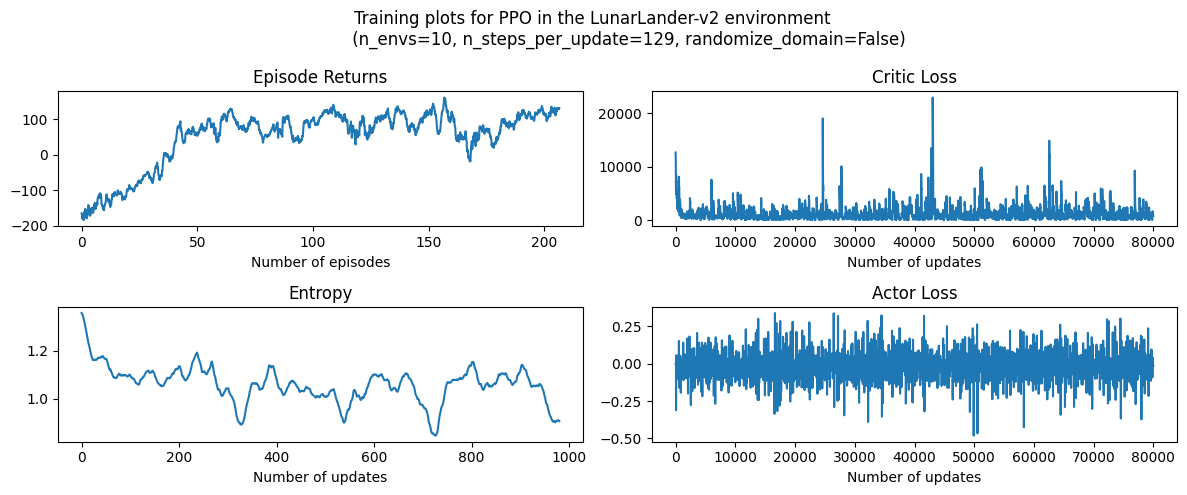

In [5]:
# %matplotlib inline

rolling_length = 20
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
fig.suptitle(
    f"Training plots for {agent.__class__.__name__} in the LunarLander-v2 environment \n \
            (n_envs={n_envs}, n_steps_per_update={n_steps_per_update}, randomize_domain={randomize_domain})"
)

# episode return
axs[0][0].set_title("Episode Returns")
episode_returns_moving_average = (
    np.convolve(
        np.array(envs_wrapper.return_queue).flatten(),
        np.ones(rolling_length),
        mode="valid",
    )
    / rolling_length
)
axs[0][0].plot(
    np.arange(len(episode_returns_moving_average)) / n_envs,
    episode_returns_moving_average,
)
axs[0][0].set_xlabel("Number of episodes")

# entropy
axs[1][0].set_title("Entropy")
entropy_moving_average = (
    np.convolve(np.array(entropies), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][0].plot(entropy_moving_average)
axs[1][0].set_xlabel("Number of updates")


# critic loss
axs[0][1].set_title("Critic Loss")
critic_losses_moving_average = (
    np.convolve(
        np.array(critic_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0][1].plot(critic_losses_moving_average)
axs[0][1].set_xlabel("Number of updates")


# actor loss
axs[1][1].set_title("Actor Loss")
actor_losses_moving_average = (
    np.convolve(np.array(actor_losses).flatten(), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][1].plot(actor_losses_moving_average)
axs[1][1].set_xlabel("Number of updates")

plt.tight_layout()
plt.show()



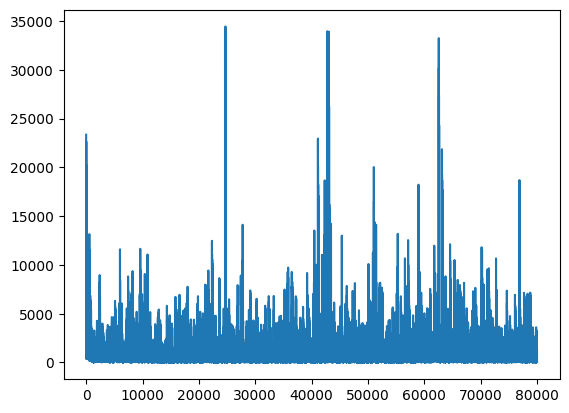

In [6]:
# plt.plot(np.array(envs_wrapper.return_queue).flatten())
plt.plot(critic_losses)

[array(1.3749025, dtype=float32),
 array(1.3833671, dtype=float32),
 array(1.3817616, dtype=float32),
 array(1.3823305, dtype=float32),
 array(1.3761566, dtype=float32),
 array(1.3706719, dtype=float32),
 array(1.3596653, dtype=float32),
 array(1.3490725, dtype=float32),
 array(1.3601748, dtype=float32),
 array(1.3583609, dtype=float32)]

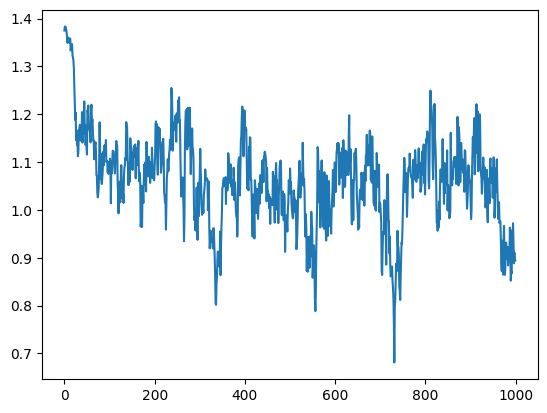

In [7]:
plt.plot(entropies[:1000])
# plt.plot(pred_values, label='pred_values')
# plt.yscale('log')
# plt.legend()
entropies[:10]

In [8]:
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

num_eval_episodes = 4

env = gym.make("LunarLander-v2", render_mode="rgb_array", max_episode_steps=500)
env = RecordVideo(env, video_folder="luna_ppo", name_prefix="eval",
                  episode_trigger=lambda x: True)
env = RecordEpisodeStatistics(env, deque_size=num_eval_episodes)

agent.actor.eval()
agent.critic.eval()

for episode_num in range(num_eval_episodes):
    state, info = env.reset()

    episode_over = False
    while not episode_over:
        action, _, _, _ = agent.select_action(state[None, :])
        state, reward, terminated, truncated, info = env.step(action.item())

        episode_over = terminated or truncated
env.close()

# print(f'Episode time taken: {env.time_queue}')
print(f'Episode total rewards: {env.return_queue}')
print(f'Episode lengths: {env.length_queue}')

/home/zhaoyutian/rl/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/zhaoyutian/rl_experiments/luna_ppo folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /home/zhaoyutian/rl_experiments/luna_ppo/eval-episode-0.mp4.
Moviepy - Writing video /home/zhaoyutian/rl_experiments/luna_ppo/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/zhaoyutian/rl_experiments/luna_ppo/eval-episode-0.mp4
Moviepy - Building video /home/zhaoyutian/rl_experiments/luna_ppo/eval-episode-1.mp4.
Moviepy - Writing video /home/zhaoyutian/rl_experiments/luna_ppo/eval-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/zhaoyutian/rl_experiments/luna_ppo/eval-episode-1.mp4
Moviepy - Building video /home/zhaoyutian/rl_experiments/luna_ppo/eval-episode-2.mp4.
Moviepy - Writing video /home/zhaoyutian/rl_experiments/luna_ppo/eval-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /home/zhaoyutian/rl_experiments/luna_ppo/eval-episode-2.mp4
Moviepy - Building video /home/zhaoyutian/rl_experiments/luna_ppo/eval-episode-3.mp4.
Moviepy - Writing video /home/zhaoyutian/rl_experiments/luna_ppo/eval-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /home/zhaoyutian/rl_experiments/luna_ppo/eval-episode-3.mp4
Episode total rewards: deque([array([150.63739], dtype=float32), array([135.94904], dtype=float32), array([189.0242], dtype=float32), array([171.40024], dtype=float32)], maxlen=4)
Episode lengths: deque([array([500], dtype=int32), array([500], dtype=int32), array([500], dtype=int32), array([500], dtype=int32)], maxlen=4)


In [9]:
save_weights = True
load_weights = False

date_time = datetime.now().strftime("%d%H%M")
actor_weights_path = f"weights/actor_weights_{date_time}.h5"
critic_weights_path = f"weights/critic_weights_{date_time}.h5"

if not os.path.exists("weights"):
    os.mkdir("weights")

""" save network weights """
if save_weights:
    torch.save(agent.actor.state_dict(), actor_weights_path)
    torch.save(agent.critic.state_dict(), critic_weights_path)


""" load network weights """
if load_weights:
    agent = PPO(obs_shape, action_shape, device, critic_lr, actor_lr)

    agent.actor.load_state_dict(torch.load(actor_weights_path))
    agent.critic.load_state_dict(torch.load(critic_weights_path))
    agent.actor.eval()
    agent.critic.eval()